In [1]:
require 'cudnn'
require 'inn'
require 'image'
require 'dcnn'

-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local file = io.open 'synset_words.txt'
  local list = {}
  while true do
    local line = file:read()
    if not line then break end
    table.insert(list, string.sub(line,11))
  end
  return list
end

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 
print '==> Loading network'

--net = torch.load('/home/yusheng/Workspace/DeepLearning/models/zeilerNet/zeilerNet.net')
net = torch.load('/usr/local/data/zeilerNet/zeilerNet.net')
net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading synsets'
synset_words = load_synset()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
--image_name = 'lena.jpg'
--image_name='people2.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

-- Replace pooling by dual pooling
unpooling_layers = dcnn:ReplaceDualPoolingModule(net:get(1))

_,classes = net:forward(I:cuda()):view(-1):float():sort(true)

for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

==> Loading network	


==> Loading synsets	
==> Loading image and imagenet mean	


==> Preprocessing	


predicted class 1: 	goldfish, Carassius auratus	
predicted class 2: 	macaw	
predicted class 3: 	flamingo	
predicted class 4: 	axolotl, mud puppy, Ambystoma mexicanum	
predicted class 5: 	eft	


In [2]:
local SpatialDeconvolution, parent = torch.class('SpatialDeconvolution', 'cudnn.SpatialConvolution')


function SpatialDeconvolution:__init( convLayer, reconstruction_size, neuron_num, normal_deconv )
    assert( torch.typename(convLayer) == 'cudnn.SpatialConvolution', 'Input should be cudnn.SpatialConvolution()')
    parent.__init(self, convLayer.nOutputPlane, convLayer.nInputPlane, convLayer.kW, convLayer.kH, convLayer.dW, 
                  convLayer.dH, convLayer.padW, convLayer.padH, convLayer.groups)
    self:reset() 
    
    self.normal_deconv = normal_deconv or false
    self.neuron_num = neuron_num or 0
    if self.neuron_num == true then
        self.neuron_num = 0 
        self.normal_deconv = true
    end
    
    if self.neuron_num == false then
        self.neuron_num = 0 
        self.normal_deconv = false
    end 
    
    
    self.reconstruction_size = reconstruction_size
    self.weight=convLayer.weight:clone()
        
    flip = function(m,d) return m:index(d,torch.range(m:size(d),1,-1):long())end
    self.weight = flip(flip(self.weight,4),3)
    self.gradWeight=convLayer.gradWeight    
end

function SpatialDeconvolution:updateOutput(input)
    local deconv_output = self.nInputPlane
    local total_deconv = self.nInputPlane
    if torch.type(self.neuron_num)~='torch.IntTensor' and self.neuron_num ~= 0 then
        total_deconv = 1
        deconv_output = 1
    end    
    
    if torch.type(self.neuron_num) == 'torch.IntTensor' then
        total_deconv = self.neuron_num:size(1)
        deconv_output = 1
    end
    
    if normal_deconv == true then
        deconv_output = 1
    end
            
    local deconv_fm = torch.CudaTensor( deconv_output, self.nOutputPlane, self.reconstruction_size, 
                                         self.reconstruction_size):zero():cuda()
    local deconv = cudnn.SpatialConvolution(1, 1, self.kW, self.kH, 1, 1, 
                                            math.floor(self.kW/2), math.floor(self.kH/2)):cuda()
    
    local conv_scat_fm = torch.zeros(total_deconv, self.reconstruction_size, self.reconstruction_size):cuda()
    local stride_size = self.dH
    local padding_size = (self.reconstruction_size - (input:size(2) * stride_size))/2
    
    local n=input:size(2)
    local x=stride_size
    input:cuda()
   
    --timer = torch.Timer()
    if self.reconstruction_size ~= input:size(2) then
        -- Scatter     contributed by TingFan
        local idx=torch.LongTensor(n*n,1):cuda()
        local counter=1;
        for i=x,n*x,x do
            for j=x,n*x,x do
                idx[counter]=(i+math.floor(padding_size)) *(n*x+padding_size*2) + j + math.floor(padding_size)
                counter=counter+1;
            end
        end

        local total_size = (n*x+padding_size*2)*(n*x+padding_size*2)
        for i=1,total_deconv do
            local fm_index = i
            
            if torch.type(self.neuron_num) ~= 'torch.IntTensor' then
                if self.neuron_num ~= 0 then
                     fm_index = self.neuron_num
                end
            else
                fm_index = self.neuron_num[i]
            end
                
            local m=torch.zeros(n*x+padding_size*2,n*x+padding_size*2):cuda()
            local output = input[fm_index]:view(n*n,1)
            m:view(total_size,1):scatter(1,idx,output)
            conv_scat_fm[i] = m
        end      
    else
        if torch.type(self.neuron_num) ~= 'torch.IntTensor' and self.neuron_num ~= 0 then
            conv_scat_fm[{{1},{},{}}] = input[{{self.neuron_num},{},{}}]:clone()
        elseif torch.type(self.nuuron_num) == 'torch.IntTensor' then
            for i=1,self.nuuron_num:size(1) do
                conv_scat_fm[i] = input[{{self.neuron_num[i]},{},{}}]:clone()
            end
        else
            conv_scat_fm = input:clone()
        end
    end
        
    --print('==> Scatter Time elapsed: ' .. timer:time().real .. ' seconds')
    --timer2 = torch.Timer()
    -- Deconv
    if self.normal_deconv == false then
        if torch.type(self.neuron_num) ~= 'torch.IntTensor' then -- single_neuron
            for i=1, total_deconv do
                for j=1, self.nOutputPlane do
                    local weight_index = i
                    if self.neuron_num ~= 0 then
                        weight_index = self.neuron_num
                    end

                    local fm = conv_scat_fm[i]
                    deconv.weight = self.weight[weight_index][j]:clone()
                    local deconv_result = deconv:forward(fm:view(1, self.reconstruction_size, self.reconstruction_size):cuda())
                    -- BGR to RGB
                    if self.nOutputPlane==3 then
                        deconv_fm[{ {i}, {3-(j-1)}, {}, {} }] = deconv_result
                    else
                        deconv_fm[{ {i}, {j}, {}, {} }] = deconv_result
                    end            
                end
            end      
        else
            for i=1, total_deconv do
                for j=1, self.nOutputPlane do
                    local weight_index = i
                    weight_index = self.neuron_num[i]
                    local fm = conv_scat_fm[i]
                    deconv.weight = self.weight[weight_index][j]:clone()
                    local deconv_result = deconv:forward(fm:view(1, self.reconstruction_size, self.reconstruction_size)):cuda()
                    -- BGR to RGB
                    if self.nOutputPlane==3 then
                        deconv_fm[{ {1}, {3-(j-1)}, {}, {} }] = deconv_fm[{ {1}, {3-(j-1)}, {}, {} }] + deconv_result
                    else
                        deconv_fm[{ {1}, {j}, {}, {} }] = deconv_fm[{ {1}, {j}, {}, {} }] + deconv_result
                    end                       
                end
            end
        end
    else
        local deconv_normal = cudnn.SpatialConvolution( self.nInputPlane, self.nOutputPlane, self.kW, self.kH, 1, 1, 
                                                        math.floor(self.kW/2), math.floor(self.kH/2), self.group):cuda()         
        deconv_normal.weight = torch.CudaTensor( self.nOutputPlane, self.nInputPlane, self.kW, self.kH )
        
        timer2 = torch.Timer()
        deconv_normal.weight = self.weight:transpose(1, 2):contiguous()          
        deconv_fm = deconv_normal:forward(conv_scat_fm):cuda()
        -- BGR to RGB
        if self.nOutputPlane==3 then
          local temp = deconv_fm:clone()
          deconv_fm[{1,{},{}}] = temp[{3,{},{}}]
          deconv_fm[{3,{},{}}] = temp[{1,{},{}}]   
        end
    end   
    
    --print('==> Deconv Time elapsed: ' .. timer2:time().real .. ' seconds')
    cutorch.synchronize()
    if deconv_fm:dim() == 4 and deconv_output==1 then
        self.output = deconv_fm[1]
        return deconv_fm[1]:clone() 
    end    
    
    self.output = deconv_fm
    return deconv_fm
end 



==> Time elapsed: 0.24372792243958 seconds	


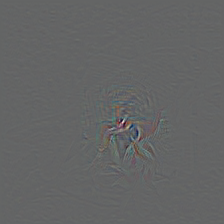

In [8]:
-- set deconvNet
local deconvNet = nn.Sequential()

local conv5_fm = net:get(1):get(13).output
deconvNet:add(SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), 27 ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))




deconv_timer = torch.Timer()
vis_c5 = deconvNet:forward(conv5_fm)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)

In [9]:
-- conv1_fm = net:get(1):get(1).output
-- deconv1 = SpatialDeconvolution( net:get(1):get(1), I:size(2), false )
-- vis_c1 = deconv1:forward(conv1_fm)
-- itorch.image(vis_c1)

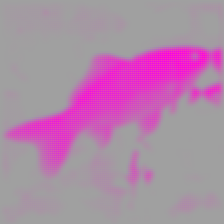

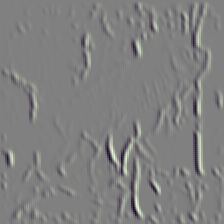

In [4]:
conv1_fm = net:get(1):get(1).output
deconv1 = SpatialDeconvolution( net:get(1):get(1), I:size(2), 47 )
vis_1 = deconv1:forward(conv1_fm)

deconv1 = SpatialDeconvolution( net:get(1):get(1), I:size(2), 94 )
vis_2 = deconv1:forward(conv1_fm)

itorch.image(vis_1)
itorch.image(vis_2)

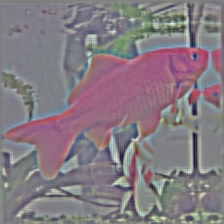

In [6]:
conv1_fm = net:get(1):get(1).output
deconv_idx = torch.IntTensor(96)
--deconv_idx[1] = 47
--deconv_idx[2] = 94

for i=1,96 do
   deconv_idx[i]=i 
end
    
deconv1 = SpatialDeconvolution( net:get(1):get(1), I:size(2), deconv_idx  )
vis_n = deconv1:forward(conv1_fm)

itorch.image(vis_n)


 256
  26
  26
[torch.LongStorage of size 3]



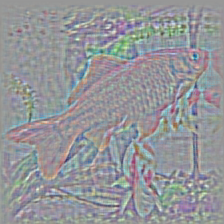

In [6]:
conv2_fm = net:get(1):get(5).output
print(conv2_fm:size() )

deconv_idx = torch.IntTensor(256)
for i=1,256 do
   deconv_idx[i]=i 
end

deconv2 = nn.Sequential()
deconv2:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), deconv_idx ))
deconv2:add(unpooling_layers[1])
deconv2:add(cudnn.ReLU(true))
deconv2:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))

vis_c2 = deconv2:forward(conv2_fm)
itorch.image(vis_c2)


 384
  13
  13
[torch.LongStorage of size 3]



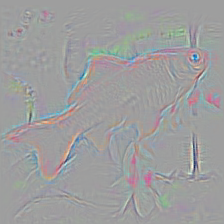

In [9]:
conv3_fm = net:get(1):get(9).output
print(conv3_fm:size() )

deconv_idx = torch.IntTensor(384)
for i=1,384 do
   deconv_idx[i]=i 
end

deconv3 = nn.Sequential()

deconv3:add(SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), deconv_idx ))
deconv3:add(unpooling_layers[2])
deconv3:add(cudnn.ReLU(true))
deconv3:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconv3:add(unpooling_layers[1])
deconv3:add(cudnn.ReLU(true))
deconv3:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))

vis_c3 = deconv3:forward(conv3_fm)
itorch.image(vis_c3)


 384
  13
  13
[torch.LongStorage of size 3]



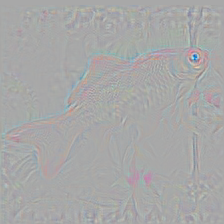

In [13]:
conv4_fm = net:get(1):get(11).output
print(conv4_fm:size() )

deconv_idx = torch.IntTensor(384)
for i=1,384 do
   deconv_idx[i]=i 
end


deconv4 = nn.Sequential()

deconv4:add(SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), deconv_idx ))
deconv4:add(cudnn.ReLU(true))
deconv4:add(SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconv4:add(unpooling_layers[2])
deconv4:add(cudnn.ReLU(true))
deconv4:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconv4:add(unpooling_layers[1])
deconv4:add(cudnn.ReLU(true))
deconv4:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))

vis_c4 = deconv4:forward(conv4_fm)
itorch.image(vis_c4)


 256
  13
  13
[torch.LongStorage of size 3]



==> Time elapsed: 10.653965950012 seconds	


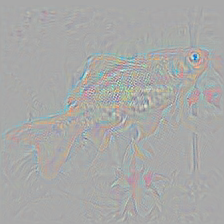

In [14]:
conv5_fm = net:get(1):get(13).output
print(conv5_fm:size() )

deconv_idx = torch.IntTensor(256)
for i=1,256 do
   deconv_idx[i]=i 
end




deconvNet = nn.Sequential()

deconvNet:add(SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), deconv_idx ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))




deconv_timer = torch.Timer()
vis_c5 = deconvNet:forward(conv5_fm)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)

In [4]:
function dcnn:CreateDeconvNet( net, unpooling_layers, input_img, layer_num, neuron_index, normal_deconv  )
    neuron_index = neuron_index or 0
    if neuron_index == true then
        neuron_index = 0 
        normal_deconv = true
    end
    
    if neuron_index == false then
        neuron_index = 0 
        normal_deconv = false
    end 
    
    local deconvNet = nn.Sequential()
    local first_deconv = true
    for i=layer_num,1,-1 do
        if torch.typename( net:get(i)) == 'cudnn.SpatialConvolution' then
            local reconstructed_size = 0
            if i==1 then
                reconstructed_size = input_img:size(2)
            else    
                reconstructed_size = net:get(i-1).output:size(2)
            end
                
            if first_deconv == true then
                --print( net:get(i) )
                if neuron_index ~= 0 then 
                    deconvNet:add( cudnn.SpatialDeconvolution( net:get(i), reconstructed_size, neuron_index ))
                    --print(neuron_index)
                else
                    deconvNet:add( cudnn.SpatialDeconvolution( net:get(i), reconstructed_size, normal_deconv ))
                end
                
                first_deconv = false
            else
                deconvNet:add( cudnn.SpatialDeconvolution( net:get(i), reconstructed_size, true ))
            end
            
        elseif torch.typename( net:get(i)) == 'dcnn.DualSpatialMaxPooling' then
            local unpooling_idx = 1
            for j=i,1,-1 do  
                if j-1 > 1 and torch.typename( net:get(j-1)) == 'dcnn.DualSpatialMaxPooling' then
                   unpooling_idx = unpooling_idx + 1
                end
            end
            
            deconvNet:add( unpooling_layers[unpooling_idx])
        
        elseif torch.typename( net:get(i)) == 'cudnn.ReLU' then
            deconvNet:add( cudnn.ReLU(true) )
            
        else
            print( torch.typename( net:get(i))..' This type of layer is not supported !')
        end
        
        --print('Layer '..i..' is complete ')
    end    
        
    --deconvNet:cuda()
    return deconvNet
end

inn.SpatialSameResponseNormalization This type of layer is not supported !	


inn.SpatialSameResponseNormalization This type of layer is not supported !	


==> Time elapsed: 0.23875498771667 seconds	


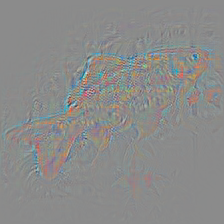

In [5]:
deconvNet_test2 = dcnn:CreateDeconvNet( net:get(1), unpooling_layers, I, 13, 153 )
deconv_timer3 = torch.Timer()
vis_c5_test2 = deconvNet_test2:forward(net:get(1):get(13).output)

print('==> Time elapsed: ' .. deconv_timer3:time().real .. ' seconds')
itorch.image(vis_c5_test2 )



In [92]:
deconvNet_test2

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> output]
  (1): cudnn.SpatialDeconvolution(256 -> 384, 3x3, 1,1, 1,1)
  (2): cudnn.ReLU
  (3): cudnn.SpatialDeconvolution(384 -> 384, 3x3, 1,1, 1,1)
  (4): cudnn.ReLU
  (5): cudnn.SpatialDeconvolution(384 -> 256, 3x3, 1,1, 1,1)
  (6): dcnn.DualSpatialMaxUnpooling
  (7): cudnn.ReLU
  (8): cudnn.SpatialDeconvolution(256 -> 96, 5x5, 2,2)
  (9): dcnn.DualSpatialMaxUnpooling
  (10): cudnn.ReLU
  (11): cudnn.SpatialDeconvolution(96 -> 3, 7x7, 2,2, 1,1)
}
{
  gradInput : DoubleTensor - empty
  modules : 
    {
      1 : 
        cudnn.SpatialDeconvolution(256 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 27
          iSize : LongStorage - size: 4
          normal_deconv : false
          groups : 1
          dH : 1
          dW : 1
          nOutputPl

      kW : 3
          reconstruction_size : 13
          bias : DoubleTensor - size: 384
          gradBias : DoubleTensor - size: 384
        }
      2 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 384x13x13
          gradInput : DoubleTensor - empty
          nElem : 64896
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x414c4870
        }
      3 : 
        cudnn.SpatialDeconvolution(384 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0
          iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 384
          padH : 1
          kH : 3
          weight : CudaTensor - size: 384x384x3x3
   

       gradWeight : CudaTensor - size: 384x384x3x3
          kW : 3
          reconstruction_size : 13
          bias : DoubleTensor - size: 384
          gradBias : DoubleTensor - size: 384
        }
      4 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 384x13x13
          gradInput : DoubleTensor - empty
          nElem : 64896
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41f6ae80
        }
      5 : 
        cudnn.SpatialDeconvolution(384 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0
          iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 1
          kH : 3
         

 weight : CudaTensor - size: 384x256x3x3
          gradWeight : CudaTensor - size: 384x256x3x3
          kW : 3
          reconstruction_size : 13
          bias : DoubleTensor - size: 256
          gradBias : DoubleTensor - size: 256
        }
      6 : 
        dcnn.DualSpatialMaxUnpooling
        {
          gradInput : CudaTensor - empty
          dualModule : 
            dcnn.DualSpatialMaxPooling(3,3,2,2)
            {
              dH : 2
              dW : 2
              padH : 0
              gradInput : CudaTensor - empty
              indices : CudaTensor - size: 256x13x13
              dualModule : 
                dcnn.DualSpatialMaxUnpooling
                {
                  gradInput : CudaTensor - empty
                  dualModule : dcnn.DualSpatialMaxPooling(3,3,2,2)
                  output : CudaTensor - size: 256x26x26
                }
              kH : 3
 

             output : CudaTensor - size: 256x13x13
              padW : 0
              kW : 3
            }
          output : CudaTensor - size: 256x26x26
        }
      7 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 256x26x26
          gradInput : DoubleTensor - empty
          nElem : 173056
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41c88ae0
        }
      8 : 
        cudnn.SpatialDeconvolution(256 -> 96, 5x5, 2,2)
        {
          padW : 0
          nInputPlane : 256
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0
          iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 2
          dW : 2
          nOutputPlane : 96
          padH : 0
          kH : 5
 

         weight : CudaTensor - size: 256x96x5x5
          gradWeight : CudaTensor - size: 256x96x5x5
          kW : 5
          reconstruction_size : 55
          bias : DoubleTensor - size: 96
          gradBias : DoubleTensor - size: 96
        }
      9 : 
        dcnn.DualSpatialMaxUnpooling
        {
          gradInput : CudaTensor - empty
          dualModule : 
            dcnn.DualSpatialMaxPooling(3,3,2,2)
            {
              dH : 2
              dW : 2
              padH : 0
              gradInput : CudaTensor - empty
              indices : CudaTensor - size: 96x55x55
              dualModule : 
                dcnn.DualSpatialMaxUnpooling
                {
                  gradInput : CudaTensor - empty
                  dualModule : dcnn.DualSpatialMaxPooling(3,3,2,2)
                  output : CudaTensor - size: 96x110x110
                }
        

      kH : 3
              output : CudaTensor - size: 96x55x55
              padW : 0
              kW : 3
            }
          output : CudaTensor - size: 96x110x110
        }
      10 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 96x110x110
          gradInput : DoubleTensor - empty
          nElem : 1161600
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41c9e6e8
        }
      11 : 
        cudnn.SpatialDeconvolution(96 -> 3, 7x7, 2,2, 1,1)
        {
          padW : 1
          nInputPlane : 96
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0
          iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 2
          dW : 2
          nOutputPlane : 3
          padH : 1
       

   kH : 7
          weight : CudaTensor - size: 96x3x7x7
          gradWeight : CudaTensor - size: 96x3x7x7
          kW : 7
          reconstruction_size : 224
          bias : DoubleTensor - size: 3
          gradBias : DoubleTensor - size: 3
        }
    }
  output : CudaTensor - size: 3x224x224
}


inn.SpatialSameResponseNormalization This type of layer is not supported !	


inn.SpatialSameResponseNormalization This type of layer is not supported !	


==> Time elapsed: 0.22721314430237 seconds	


0	


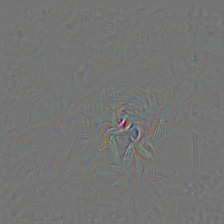

==> Time elapsed: 0.22792196273804 seconds	


2231.3088126723	


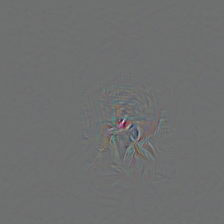

==> Time elapsed: 0.18611192703247 seconds	


2324.1703044716	


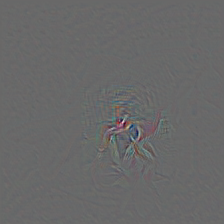

==> Time elapsed: 0.18735694885254 seconds	


-1380.4084157459	


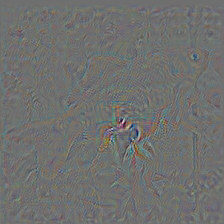

==> Time elapsed: 0.19299507141113 seconds	


2247.1502993647	


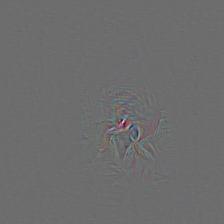

==> Time elapsed: 0.18544912338257 seconds	


-3233.9932958223	


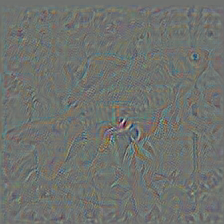

==> Time elapsed: 0.18633198738098 seconds	


2254.2693271134	


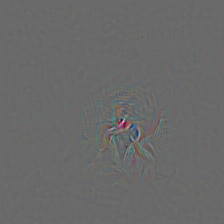

==> Time elapsed: 0.18494701385498 seconds	


-6983.3318701908	


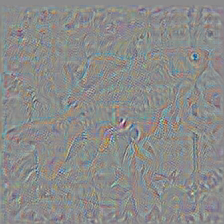

==> Time elapsed: 0.19041395187378 seconds	


2331.5626784209	


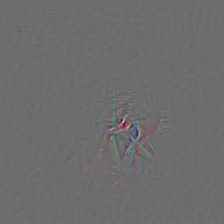

==> Time elapsed: 0.18634009361267 seconds	


1346.7344464362	


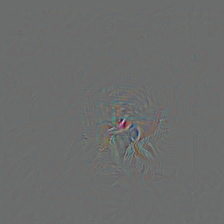

==> Time elapsed: 0.1876368522644 seconds	


-15966.368128881	


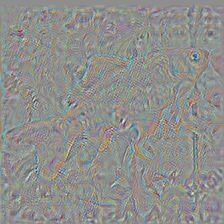

==> Time elapsed: 0.19095087051392 seconds	


121.95739882253	


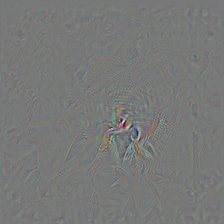

==> Time elapsed: 0.18988704681396 seconds	


-4693.8736231253	


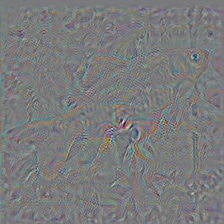

==> Time elapsed: 0.18832778930664 seconds	


-17563.625081941	


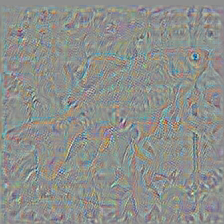

==> Time elapsed: 0.1978452205658 seconds	


2164.8381079305	


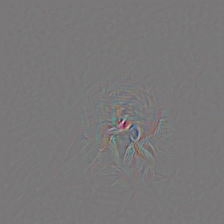

==> Time elapsed: 0.1866660118103 seconds	


-7906.4989704415	


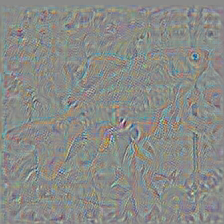

==> Time elapsed: 0.20131182670593 seconds	


-12841.683120266	


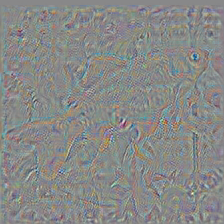

==> Time elapsed: 0.19688296318054 seconds	


1256.1727442723	


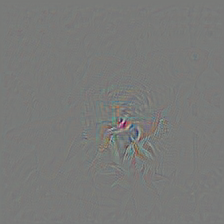

==> Time elapsed: 0.2063410282135 seconds	


-7528.271283865	


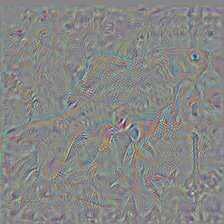

==> Time elapsed: 0.19568300247192 seconds	


2244.7611031029	


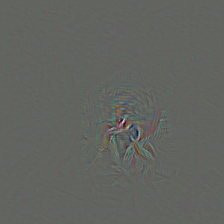

In [6]:

error_tensor = 0
last_output = 0
local last_time = 0
layer_n = 1

deconvNet_test2 = dcnn:CreateDeconvNet( net:get(layer_n), unpooling_layers, I, 13, 27 )
deconv_timer3 = torch.Timer()

for i=1,20 do
    vis_c5_test2 = deconvNet_test2:forward(net:get(1):get(13).output)

    print('==> Time elapsed: ' .. deconv_timer3:time().real-last_time .. ' seconds')    
    --print( deconvNet_test2:get(layer_n).output:size() )
    
    if i==1 then
        last_output = deconvNet_test2:get(layer_n).output
    end
    
    error_tensor = last_output - deconvNet_test2:get(layer_n).output
    local test_error = 0
    for j=1, error_tensor:view(-1):size(1) do
        test_error = test_error + error_tensor:view(-1)[j]
    end
        
    print(test_error)
    --last_output = deconvNet_test2:get(layer_n).output
    --itorch.image( deconvNet_test2:get(1).output )
    itorch.image(vis_c5_test2 )
    last_time = deconv_timer3:time().real
end

==> Time elapsed: 0.25229811668396 seconds	


0	


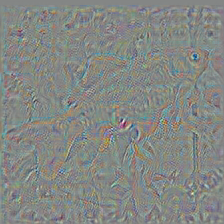

==> Time elapsed: 0.21025490760803 seconds	


2655.0427091196	


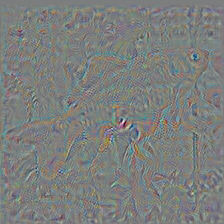

==> Time elapsed: 0.19872689247131 seconds	


-2786.919879429	


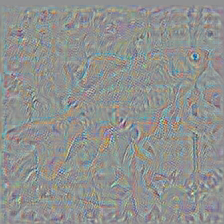

==> Time elapsed: 0.22048497200012 seconds	


12683.377342239	


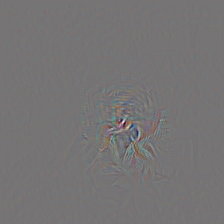

==> Time elapsed: 0.21448516845703 seconds	


20982.039424002	


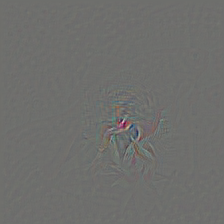

==> Time elapsed: 0.21818089485168 seconds	


-10098.889801189	


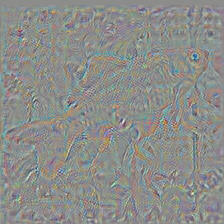

==> Time elapsed: 0.21198606491089 seconds	


22584.232811749	


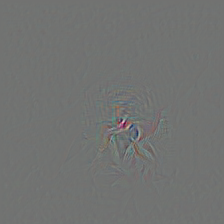

==> Time elapsed: 0.27747392654419 seconds	


14922.685024038	


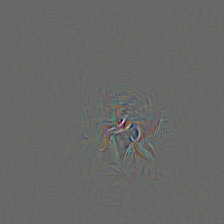

==> Time elapsed: 0.21112895011902 seconds	


-6694.0327268541	


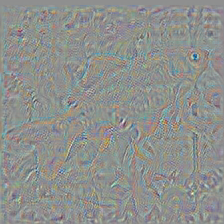

==> Time elapsed: 0.21015214920044 seconds	


6667.8108557835	


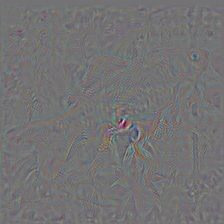

==> Time elapsed: 0.20227003097534 seconds	


30986.777662873	


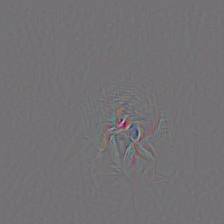

==> Time elapsed: 0.20305395126343 seconds	


14388.440053955	


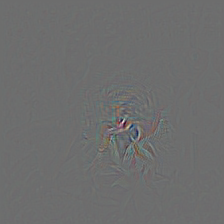

==> Time elapsed: 0.20277190208435 seconds	


32283.779687077	


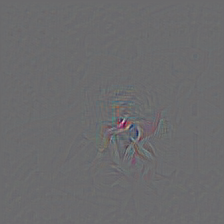

==> Time elapsed: 0.20238399505615 seconds	


6539.904292509	


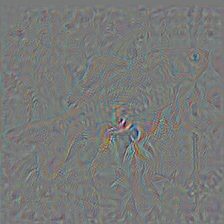

==> Time elapsed: 0.20478296279907 seconds	


-2199.0465471819	


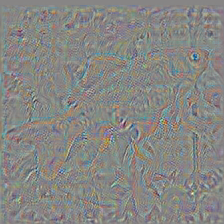

==> Time elapsed: 0.27158999443054 seconds	


24463.954913676	


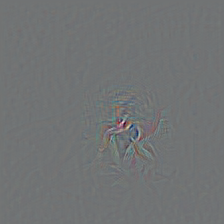

==> Time elapsed: 0.26271295547485 seconds	


18595.539767951	


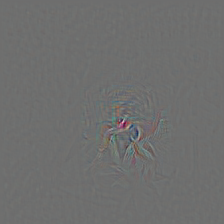

==> Time elapsed: 0.20557403564453 seconds	


13725.434631139	


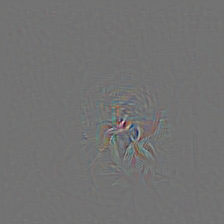

==> Time elapsed: 0.26421809196472 seconds	


24745.601196647	


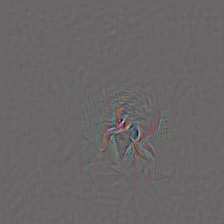

==> Time elapsed: 0.20469093322754 seconds	


18076.807810485	


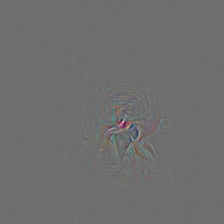

In [4]:
deconvNet = nn.Sequential()

deconvNet:add(SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), 27 ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))


layer_n = 1
deconv_timer = torch.Timer()

for i=1,20 do
    deconv_timer = torch.Timer()
    vis_c5 = deconvNet:forward(net:get(1):get(13).output)

    print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')  
    --print( deconvNet_test2:get(layer_n).output:size() )
    
    if i==1 then
        last_output = deconvNet:get(layer_n).output
        --last_output = net:get(1):get(13).output
    end
    
    error_tensor = last_output - deconvNet:get(layer_n).output
    --error_tensor = last_output-net:get(1):get(13).output
    local test_error = 0
    for j=1, error_tensor:view(-1):size(1) do
        test_error = test_error + error_tensor:view(-1)[j]
    end
        
    print(test_error)

    --itorch.image( deconvNet:get(1).output )
    itorch.image(vis_c5 )
    last_time = deconv_timer:time().real
end

